In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

import lightgbm as lgb

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import warnings

# Установка параметров для игнорирования предупреждений
warnings.filterwarnings('ignore')

pd.set_option('display.width', 200)


In [2]:
# Загрузка данных
data = pd.read_csv('data\\train.csv')

In [3]:
# Функция для извлечения обращений из имени
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Создание нового столбца 'Title' с обращениями
data['Title'] = data['Name'].apply(extract_title)

# Замена пропусков в возрасте медианой по каждому обращению
data['Age'] = data.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# Удаление столбца 'Title' после замены пропусков
data.drop('Title', axis=1, inplace=True)

In [4]:
# Находим самое частое значение в столбце 'Embarked'
most_common_embarked = data['Embarked'].mode()[0]

# Заменяем пропущенные значения в столбце 'Embarked' на самое частое значение
data['Embarked'].fillna(most_common_embarked, inplace=True)

In [5]:
# Заменим значения кабины на ближайщее среднее значение цены билета

# Условие для замены пропусков в зависимости от класса
condition_1 = (data['Pclass'] == 1) & (data['Cabin'].isnull())
condition_2 = (data['Pclass'] == 2) & (data['Cabin'].isnull())
condition_3 = (data['Pclass'] == 3) & (data['Cabin'].isnull())

# Замена пропусков в столбце "Cabin" в зависимости от класса
data.loc[condition_1, 'Cabin'] = 'D'
data.loc[condition_2, 'Cabin'] = 'F'
data.loc[condition_3, 'Cabin'] = 'G'
# Убираем все символы после первой буквы в столбце Cabin
data['Cabin'] = data['Cabin'].str[0]

In [6]:
# Преобразование категориальных переменных в числовые методом get_dummies
data = pd.get_dummies(data, columns=['Embarked', 'Sex', 'Cabin'], drop_first=True)

In [7]:
# Создаем объект LabelEncoder
label_encoder = LabelEncoder()

# Преобразуем столбец 'Name'
data['Name'] = label_encoder.fit_transform(data['Name'])

# Преобразуем столбец 'Ticket'
data['Ticket'] = label_encoder.fit_transform(data['Ticket'])

In [8]:
# Инициализация объекта MinMaxScaler
scaler = MinMaxScaler()

# Выбор числовых признаков, которые нужно масштабировать
numeric_features = ['Age', 'Fare', 'Ticket', 'Name', 'Pclass', 'SibSp', 'Parch']

# Масштабирование выбранных признаков
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [9]:
# Поиск столбцов с пропущенными значениями
columns_with_missing_values = data.columns[data.isnull().any()]

if len(columns_with_missing_values) > 0:
    print("Столбцы с пропущенными значениями:")
    for column in columns_with_missing_values:
        print(column)
else:
    print("Пропущенные значения не обнаружены.")

Пропущенные значения не обнаружены.


## LightGBM  

In [20]:
# Признаки (X) и целевая переменная (y)
X = data.drop(['Survived'], axis=1)
y = data['Survived']

In [21]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data.drop('Survived', axis=1), data['Survived'], test_size=0.2, random_state=42)

In [22]:
# Создание модели LightGBM с параметрами по умолчанию
model = lgb.LGBMClassifier()

# Обучение модели на тренировочных данных
model.fit(X_train, y_train)

# Получение предсказаний на тестовых данных
predictions = model.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Accuracy: 0.8435754189944135


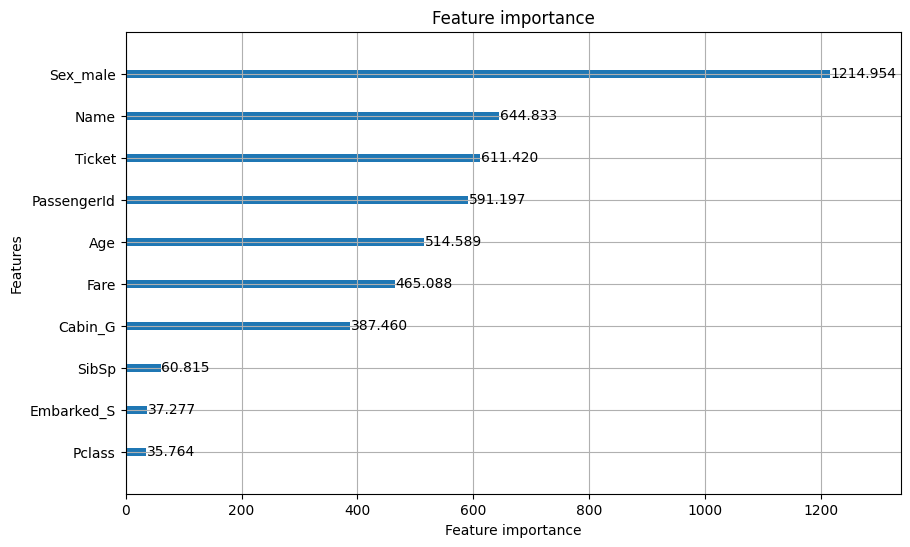

In [23]:
# Оценка производительности модели
accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
print("Accuracy:", accuracy)

# Важность признаков
lgb.plot_importance(model, figsize=(10, 6), max_num_features=10, importance_type='gain')
plt.show()

In [24]:
# Загрузка тестовых данных
test = pd.read_csv('data\\test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [25]:
# Функция для извлечения обращений из имени
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Создание нового столбца 'Title' с обращениями
test['Title'] = test['Name'].apply(extract_title)

# Замена пропусков в возрасте медианой по каждому обращению
test['Age'] = test.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# Удаление столбца 'Title' после замены пропусков
test.drop('Title', axis=1, inplace=True)
# Находим самое частое значение в столбце 'Embarked'
most_common_embarked = test['Embarked'].mode()[0]

# Заменяем пропущенные значения в столбце 'Embarked' на самое частое значение
test['Embarked'].fillna(most_common_embarked, inplace=True)
# Заменим значения кабины на ближайщее среднее значение цены билета

# Условие для замены пропусков в зависимости от класса
condition_1 = (test['Pclass'] == 1) & (test['Cabin'].isnull())
condition_2 = (test['Pclass'] == 2) & (test['Cabin'].isnull())
condition_3 = (test['Pclass'] == 3) & (test['Cabin'].isnull())

# Замена пропусков в столбце "Cabin" в зависимости от класса
test.loc[condition_1, 'Cabin'] = 'D'
test.loc[condition_2, 'Cabin'] = 'F'
test.loc[condition_3, 'Cabin'] = 'G'
# Убираем все символы после первой буквы в столбце Cabin
test['Cabin'] = test['Cabin'].str[0]
# Преобразование категориальных переменных в числовые методом get_dummies
test = pd.get_dummies(test, columns=['Embarked', 'Sex', 'Cabin'], drop_first=True)
# Создаем объект LabelEncoder
label_encoder = LabelEncoder()

# Преобразуем столбец 'Name'
test['Name'] = label_encoder.fit_transform(test['Name'])

# Преобразуем столбец 'Ticket'
test['Ticket'] = label_encoder.fit_transform(test['Ticket'])
# Инициализация объекта MinMaxScaler
scaler = MinMaxScaler()

# Выбор числовых признаков, которые нужно масштабировать
numeric_features = ['Age', 'Fare', 'Ticket', 'Name', 'Pclass', 'SibSp', 'Parch']

# Масштабирование выбранных признаков
test[numeric_features] = scaler.fit_transform(test[numeric_features])
# Поиск столбцов с пропущенными значениями
columns_with_missing_values = test.columns[test.isnull().any()]

if len(columns_with_missing_values) > 0:
    print("Столбцы с пропущенными значениями:")
    for column in columns_with_missing_values:
        print(column)
else:
    print("Пропущенные значения не обнаружены.")

Столбцы с пропущенными значениями:
Age
Fare


In [26]:
# Определение различий в столбцах между двумя наборами данных
extra_feature = set(X.columns) - set(test.columns)

# Удаление лишнего признака из DataFrame data, если такой есть
if extra_feature:
    X.drop(columns=list(extra_feature), inplace=True)
    print(f"Удален лишний признак из DataFrame X: {extra_feature}")
else:
    print("Не обнаружено лишних признаков в DataFrame X.")

# Проверка наличия дополнительных признаков в DataFrame test
extra_feature_test = set(test.columns) - set(X.columns)
if extra_feature_test:
    print(f"Дополнительные признаки в DataFrame test: {extra_feature_test}")
else:
    print("Не обнаружено дополнительных признаков в DataFrame test.")


Удален лишний признак из DataFrame X: {'Cabin_T'}
Не обнаружено дополнительных признаков в DataFrame test.


In [27]:
test

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked_Q,Embarked_S,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,892,1.0,0.494005,0.452723,0.000,0.000000,0.419890,0.015282,True,False,True,False,False,False,False,False,True
1,893,1.0,0.966427,0.617566,0.125,0.000000,0.610497,0.013663,False,True,False,False,False,False,False,False,True
2,894,0.5,0.645084,0.815377,0.000,0.000000,0.201657,0.018909,True,False,True,False,False,False,False,True,False
3,895,1.0,0.978417,0.353818,0.000,0.000000,0.406077,0.016908,False,True,True,False,False,False,False,False,True
4,896,1.0,0.426859,0.287881,0.125,0.111111,0.381215,0.023984,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,1.0,0.846523,0.373599,0.000,0.000000,0.737569,0.015713,False,True,True,False,False,False,False,False,True
414,1306,0.0,0.678657,0.512066,0.000,0.000000,0.895028,0.212559,False,False,False,False,True,False,False,False,False
415,1307,1.0,0.796163,0.505473,0.000,0.000000,0.955801,0.014151,False,True,True,False,False,False,False,False,True
416,1308,1.0,0.920863,0.373599,0.000,0.000000,0.607735,0.015713,False,True,True,False,False,False,False,False,True


In [28]:
# Создание модели LightGBM с параметрами по умолчанию
model = lgb.LGBMClassifier()

# Обучение модели на всех данных
model.fit(X, y)

# Получение предсказаний на тестовых данных
predictions = model.predict(test)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [29]:
# Создание DataFrame с предсказаниями
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predictions})

# Сохранение предсказаний в файл
submission.to_csv('gender_submission.csv', index=False)